In [1]:
# download the genbank 
!curl -L https://osf.io/cbhgd/download -o bacteria_genbank_lineages.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1000      0 --:--:-- --:--:-- --:--:--  1000
100 83.1M  100 83.1M    0     0  42.6M      0  0:00:01  0:00:01 --:--:-- 90.3M


In [13]:
# generate abundance matrix from samples
!sourmash tax summarize outputs/gather/demo_gather_x_genbank_k31.csv outputs/gather/HSMA33MX_gather_x_genbank_k31.csv \
   --output-format lineage_summary -o demo \
   -r species -t bacteria_genbank_lineages.csv


== This is sourmash version 4.1.1.dev95+gac748dc. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

loaded 6 gather results.
of 6, missed 2 lineage assignments.
The following are missing from the taxonomy information: GCA_002754635,GCA_000256725
loaded 6 gather results.
of 6, missed 2 lineage assignments.
The following are missing from the taxonomy information: GCA_002754635,GCA_000256725


In [69]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
import pylab
import scipy.cluster.hierarchy as sch

In [126]:
#notify('loading lineage summary from {}...', abund_filename)
abund_filename = "demo.lineage_summary.tsv"

with open(abund_filename) as fp:
    reader = csv.reader(fp, delimiter = "\t")
    sample_names =  next(reader)
    sample_names = sample_names[1:] # remove "lineage" from sample vector
    num_cols = len(fp.readline().split("\t"))
    fp.seek(0)
    abund = np.genfromtxt(fp, delimiter='\t', skip_header = 1, usecols = np.arange(1, num_cols))
    abund = np.around(abund, decimals=3)
    
with open(abund_filename) as fp:
    lineages = [row.split("\t")[0] for row in fp]
    lineages = lineages[1:]

full_lineage = False
if not full_lineage:
    lineages = [lineage.split(";")[-1] for lineage in lineages]
# abund = np.genfromtxt(abund_filename, delimiter='\t', skip_header = 1, usecols=range(1,num_cols))
# notify('...got {} x {} matrix.', *D.shape)

In [124]:
print(abund)
print(sample_names) 
print(lineages)

[[0.016 0.016]
 [0.057 0.057]
 [0.058 0.158]]
['demo', 'HSMA33MX']
['Bacteroides vulgatus', 'Prevotella copri', 'Escherichia coli']


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


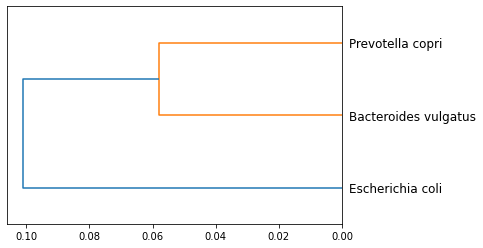

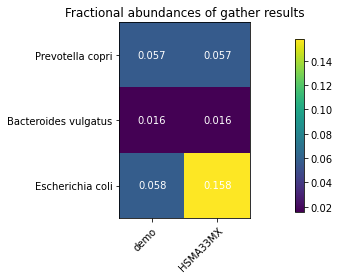

In [125]:
vmax=1.0 
vmin=0.0

# hierarchically cluster the lineages axis
Y = sch.linkage(abund, method='single')  # centroid
Z1 = sch.dendrogram(Y, orientation='left', labels=lineages,
                    get_leaves=True)

# re-order labels along rows, top to bottom
idx1 = Z1['leaves']
reordered_lineages = [ lineages[i] for i in idx1 ]

# reorder abund by the clustering in the dendrogram
abund = abund[idx1, :]

xstart = 0.315
width = 0.45
scale_xstart = xstart + width + 0.01
    
fig, ax = plt.subplots()
im = ax.imshow(abund, origin = "lower")

# Show all ticks
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(reordered_lineages)))
# Label ticks with the respective list entries
ax.set_xticklabels(sample_names)
ax.set_yticklabels(reordered_lineages)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(reordered_lineages)):
    for j in range(len(sample_names)):
        text = ax.text(j, i, abund[i, j],
                       ha="center", va="center", color="w")

# Plot colorbar.
axcolor = fig.add_axes([scale_xstart, 0.25, 0.02, 0.6])
pylab.colorbar(im, cax=axcolor)
    
ax.set_title("Fractional abundances of gather results")
fig.tight_layout()
plt.show()

In [127]:
def plot_tax_lineage_csv(abund_filename, out_file, vmin = 0.0, vmax = 1.0, full_lineage = False):
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import csv
    import pylab
    import scipy.cluster.hierarchy as sch
    
    # read in sample names and abundance data
    with open(abund_filename) as fp:
        reader = csv.reader(fp, delimiter = "\t")
        sample_names =  next(reader)
        sample_names = sample_names[1:] # remove "lineage" from sample vector
        num_cols = len(fp.readline().split("\t"))
        fp.seek(0)
        abund = np.genfromtxt(fp, delimiter='\t', skip_header = 1, usecols = np.arange(1, num_cols))
        abund = np.around(abund, decimals=3)
    
    # read in lineage names
    with open(abund_filename) as fp:
        lineages = [row.split("\t")[0] for row in fp]
        lineages = lineages[1:]

    if not full_lineage:
        lineages = [lineage.split(";")[-1] for lineage in lineages]
    
    # hierarchically cluster the lineages axis
    Y = sch.linkage(abund, method='single')  # centroid
    Z1 = sch.dendrogram(Y, orientation='left', labels=lineages,
                        get_leaves=True)

    # re-order labels along rows, top to bottom
    idx1 = Z1['leaves']
    reordered_lineages = [ lineages[i] for i in idx1 ]

    # reorder abund by the clustering in the dendrogram
    # only reorder lineage axis
    abund = abund[idx1, :]

    xstart = 0.315
    width = 0.45
    scale_xstart = xstart + width + 0.01
    
    fig, ax = plt.subplots()
    im = ax.imshow(abund, origin = "lower")

    # Show all ticks
    ax.set_xticks(np.arange(len(sample_names)))
    ax.set_yticks(np.arange(len(reordered_lineages)))
    # Label ticks with the respective list entries
    ax.set_xticklabels(sample_names)
    ax.set_yticklabels(reordered_lineages)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(reordered_lineages)):
        for j in range(len(sample_names)):
            text = ax.text(j, i, abund[i, j],
                           ha="center", va="center", color="w")

    # Plot colorbar.
    axcolor = fig.add_axes([scale_xstart, 0.25, 0.02, 0.6])
    pylab.colorbar(im, cax=axcolor)

    fig.savefig(out_file)

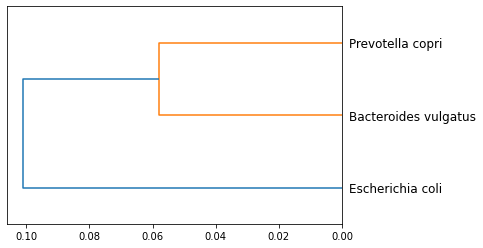

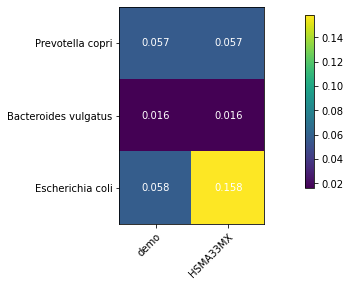

In [128]:
plot_tax_lineage_csv(abund_filename, out_file = "tmp.png", vmin = 0.0, vmax = 1.0, full_lineage = False)